In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU Device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os
from keras.callbacks import ModelCheckpoint

In [ ]:
from sklearn.model_selection import train_test_split

# Load CIFAR-10 dataset
(X_train, Y_train), (X_test,Y_test) = cifar100.load_data()

# Split training set into new training set and validation set
x_train,x_val,y_train,y_val = train_test_split(X_train, Y_train, test_size = 0.2)

# Preprocess data
x_train = x_train * 1.0/255
x_val = x_val * 1.0/255
x_test = X_test * 1.0/255
y_train = to_categorical(y_train, num_classes = 100)
y_val = to_categorical(y_val, num_classes = 100)
y_test = to_categorical(Y_test, num_classes = 100)

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

169001437/169001437 [==============================] - 4s 0us/step
(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 100) (10000, 100) (10000, 100)


In [ ]:
# Definte data augmentation generator
train_datagen = ImageDataGenerator( 
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1,  
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,  
        vertical_flip = False
        )

train_datagen.fit(x_train)

In [ ]:
# Set up callbacks
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.6, 
    min_lr=1e-6)

checkpoint = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/ResNet50/ResNet50CIFAR100.h5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto')

In [ ]:
# Load ResNet50 pre-trained on ImageNet and remove top layer
resnet_model = ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3)
)

# Freeze the weights of the base model
for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

resnet_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
# Initialise full model
model=tf.keras.models.Sequential()

# Keras provides an upsampling layer – called UpSampling2D – which allows to perform upsampling operation within neural networks
model.add(UpSampling2D(size=(7, 7),interpolation='bilinear')) 
model.add(resnet_model)

# Add new layers on top of the pre-trained model
model.add(GlobalAveragePooling2D())
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='softmax'))

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(
    optimizer = optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Build the model
model.build(input_shape=(None, None, None, None))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, None, None, None)  0        
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (BatchN  (None, 256)              1

In [ ]:
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size = 128),
    validation_data = (x_val, y_val),
    epochs = 50,
    verbose = 1,
    callbacks = [checkpoint]
)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 4.2325 - accuracy: 0.0957
Epoch 1: val_accuracy improved from -inf to 0.00970, saving model to /content/drive/MyDrive/Colab Notebooks/ResNet50/ResNet50CIFAR100.h5
313/313 [==============================] - 390s 1s/step - loss: 4.2325 - accuracy: 0.0957 - val_loss: 11.8840 - val_accuracy: 0.0097
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 3.0824 - accuracy: 0.2647
Epoch 2: val_accuracy improved from 0.00970 to 0.01330, saving model to /content/drive/MyDrive/Colab Notebooks/ResNet50/ResNet50CIFAR100.h5
313/313 [==============================] - 372s 1s/step - loss: 3.0824 - accuracy: 0.2647 - val_loss: 7.6202 - val_accuracy: 0.0133
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 2.6052 - accuracy: 0.3561
Epoch 3: val_accuracy improved from 0.01330 to 0.22790, saving model to /content/drive/MyDrive/Colab Notebooks/ResNet50/ResNet50CIFAR100.h5
313/313 [=====================

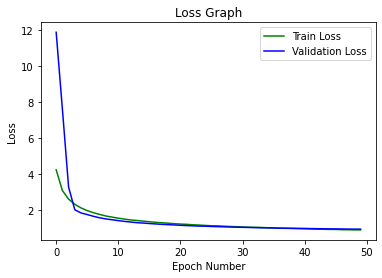

In [ ]:
plt.subplots(figsize=(6,4))
plt.plot(history.epoch,history.history["loss"],color="green",label="Train Loss")
plt.plot(history.epoch,history.history["val_loss"],color="blue",label="Validation Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Graph")
plt.show()

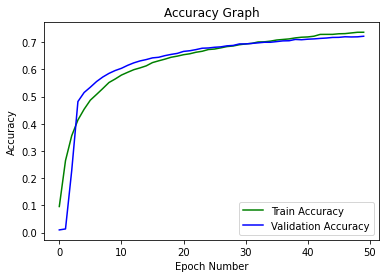

In [ ]:
plt.subplots(figsize=(6,4))
plt.plot(history.epoch,history.history["accuracy"],color="green",label="Train Accuracy")
plt.plot(history.epoch,history.history["val_accuracy"],color="blue",label="Validation Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Graph")
plt.show()

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ResNet50/ResNet50CIFAR100.hdf5") # (must run this)

In [ ]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy without attack: {:.4f}".format(test_acc))

Test accuracy without attack: 0.7335


In [ ]:
# Make predictions on the test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Find the indices of the correctly predicted samples
correct_indices = np.nonzero(y_pred_classes == y_true_classes)[0]

313/313 [==============================] - 37s 85ms/step


In [ ]:
# Select a random sample of 2500 correctly predicted samples
num_samples = 2500
selected_indices = np.random.choice(correct_indices, num_samples, replace=False)
selected_images = x_test[selected_indices]
selected_labels = y_test[selected_indices]

print('Selected images shape:', selected_images.shape)
print('Selected labels shape:', selected_labels.shape)

# Save the selected images and labels
np.save('/content/drive/MyDrive/Colab Notebooks/ResNet50/selected_images.npy', selected_images)
np.save('/content/drive/MyDrive/Colab Notebooks/ResNet50/selected_labels.npy', selected_labels)

Selected images shape: (2500, 32, 32, 3)
Selected labels shape: (2500, 100)


In [ ]:
import tensorflow as tf
import numpy as np

selected_images = np.load('/content/drive/MyDrive/Colab Notebooks/ResNet50/selected_images.npy')
selected_labels = np.load('/content/drive/MyDrive/Colab Notebooks/ResNet50/selected_labels.npy')
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ResNet50/ResNet50CIFAR100.hdf5")

**Generating Adversarial Examples using Fast Gradient Sign Method (FGSM)**

In [ ]:
# Define the FGSM attack function
def fgsm_attack(model, images, labels, eps, batch_size=50):
  
    adv_images = []
    num_batches = int(np.ceil(len(images) / batch_size))
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(images))
        batch_images = images[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx]

        # Compute the gradient of the loss with respect to the input
        x_tensor = tf.convert_to_tensor(batch_images, dtype=tf.float32)
        # Record the gradient tape
        with tf.GradientTape() as tape:
            tape.watch(x_tensor)
            y_pred = model(x_tensor)
            loss_value = tf.keras.losses.categorical_crossentropy(batch_labels, y_pred)
        gradient = tape.gradient(loss_value, x_tensor)

        # Generate the adversarial examples with FGSM
        adv_images_batch = batch_images + eps * tf.sign(gradient)
        adv_images_batch = tf.clip_by_value(adv_images_batch, 0, 1)
    
        # Compute the adversarial examples for the batch
        adv_images.extend(adv_images_batch.numpy())
    
    return adv_images

In [ ]:
# Perform the FGSM attack on the sample of test images
eps = 0.1
adv_images = fgsm_attack(model, selected_images, selected_labels, eps)

# Save the adversarial images to a numpy file
np.save('/content/drive/MyDrive/Colab Notebooks/ResNet50/adv_images_fgsm.npy', adv_images)
# Evaluate the accuracy of the classification on the original and perturbed images
acc_orig = model.evaluate(selected_images, selected_labels, verbose=0)[1]
acc_adv = model.evaluate(np.array(adv_images), selected_labels, verbose=0)[1]

print('Accuracy of benign images: {:4f}'.format(acc_orig))
print('Accuracy of adversarial examples: {:4f}'.format(acc_adv))

Accuracy of benign images: 1.000000
Accuracy of adversarial examples: 0.042800


**Defence against FGSM Attack**

In [ ]:
# Load the ifgsm adversarial images from the numpy file 
import numpy as np
import tensorflow as tf

num_samples = 2500
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ResNet50/ResNet50CIFAR100.hdf5")
adv_images = np.load('/content/drive/MyDrive/Colab Notebooks/ResNet50/adv_images_fgsm.npy')

In [ ]:
import cv2
from PIL import Image
from io import BytesIO
import datetime

# Perform fliplr on the adversarial images
x_fliplr = np.fliplr(adv_images)

for quality in [0, 25, 50, 75, 100]:
    print('--- For Quality Factor : {} ---'.format(quality))
    # Save the fliplr adversarial images and perform webp compression
    start_time = datetime.datetime.now()

    for i in range(num_samples):
        img = Image.fromarray(np.uint8(x_fliplr[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/ResNet50/Images/fliplr_adv_{}_{}.webp'.format(i, quality), 'webp', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average time taken to save 1 fliplr adversarial image with webp compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))

    start_time = datetime.datetime.now()

    # Perform webp compression on the adversarial images without fliplr
    for i in range(num_samples):
        img = Image.fromarray(np.uint8(adv_images[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/ResNet50/Images/adv_{}_{}.webp'.format(i, quality), 'webp', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average time taken to save 1 original adversarial image with webp compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))

    start_time = datetime.datetime.now()
    
    # Perform jpg compression on the adversarial images without fliplr
    for i in range(num_samples):
        img = Image.fromarray(np.uint8(adv_images[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/ResNet50/Images/adv_{}_{}.jpg'.format(i, quality), 'jpeg', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average Time taken to save 1 original adversarial image with jpg compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))
    
     # Load the fliplr adversarial images
    x_fliplr = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/ResNet50/Images/fliplr_adv_{}_{}.webp'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the fliplr adversarial examples
    y_pred = model.predict(x_fliplr)
    acc_fliplr = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with fliplr and webp compression:', acc_fliplr)

    # Load the webp compressed adversarial images
    x_webp = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/ResNet50/Images/adv_{}_{}.webp'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the webp compressed adversarial examples
    y_pred = model.predict(x_webp)
    acc_webp = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with webp compression:', acc_webp)

    # Load the jpg compressed adversarial images
    x_jpg = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/ResNet50/Images/adv_{}_{}.jpg'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the jpg compressed adversarial examples
    y_pred = model.predict(x_jpg)
    acc_jpg = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with jpeg compression:', acc_jpg)

--- For Quality Factor : 0 ---
Average time taken to save 1 fliplr adversarial image with webp compression: 0.0052 seconds
Average time taken to save 1 original adversarial image with webp compression: 0.0050 seconds
Average Time taken to save 1 original adversarial image with jpg compression: 0.0049 seconds
79/79 [==============================] - 7s 84ms/step
Accuracy on adversarial examples with fliplr and webp compression: 0.0804
79/79 [==============================] - 7s 85ms/step
Accuracy on adversarial examples with webp compression: 0.1416
79/79 [==============================] - 7s 85ms/step
Accuracy on adversarial examples with jpeg compression: 0.0368
--- For Quality Factor : 25 ---
Average time taken to save 1 fliplr adversarial image with webp compression: 0.0052 seconds
Average time taken to save 1 original adversarial image with webp compression: 0.0051 seconds
Average Time taken to save 1 original adversarial image with jpg compression: 0.0049 seconds
79/79 [==========

**Generating Adversarial Examples using Iterative Fast Gradient Sign Method (IFGSM)** 

In [ ]:
def ifgsm_batch(model, images, labels, eps=0.01, alpha=0.005, num_iter=10, batch_size=50):
    """
    Implements the iterative fast gradient sign method (IFGSM) attack on a given model.
    
    Args:
    - model: the target model to attack
    - images: a batch of input images to be attacked
    - labels: the true labels for the input images
    - eps: the maximum perturbation that can be added to each pixel (default: 0.01)
    - alpha: the step size for each iteration of the attack (default: 0.005)
    - num_iter: the number of iterations to run the attack (default: 10)
    - batch_size: the number of images to attack at once (default: 50)
    
    Returns:
    - adv_images: the adversarial images generated by the attack
    """
    adv_images = []
    num_batches = int(np.ceil(len(images) / batch_size))
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(images))
        batch_images = images[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx]

        # Create a tensor from the batch images
        x = tf.convert_to_tensor(batch_images, dtype=tf.float32)

        # Iterate the FGSM attack
        for j in range(num_iter):
            with tf.GradientTape() as tape:
                tape.watch(x)
                pred = model(x)
                loss = tf.keras.losses.categorical_crossentropy(batch_labels, pred)
            grad = tape.gradient(loss, x)
            signed_grad = tf.sign(grad)
            x += alpha * signed_grad
            x = tf.clip_by_value(x, 0, 1)

        # Compute the adversarial examples for the batch
        adv_images_batch = x.numpy()
        adv_images.extend(adv_images_batch)

    return np.array(adv_images)


In [ ]:
# Generate adversarial examples using IFGSM
adv_images = ifgsm_batch(model, selected_images, selected_labels, eps=0.01, alpha=0.005, num_iter=10, batch_size=50)
num_samples = 2500

# Save the adversarial images to a numpy file
np.save('/content/drive/MyDrive/Colab Notebooks/ResNet50/adv_images_ifgsm.npy', adv_images)

# Evaluate the accuracy of the classification on the original and perturbed images
acc_orig = model.evaluate(selected_images, selected_labels, verbose=0)[1]
acc_adv = model.evaluate(np.array(adv_images), selected_labels, verbose=0)[1]

print('Accuracy of benign images: {:4f}'.format(acc_orig))
print('Accuracy of adversarial examples: {:4f}'.format(acc_adv))

Accuracy of benign images: 1.000000
Accuracy of adversarial examples: 0.000000


**Defence against Iterative FGSM Attack**

In [ ]:
# Load the pgd adversarial images from the numpy file 
import numpy as np
import tensorflow as tf

num_samples = 2500
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ResNet50/ResNet50CIFAR100.hdf5")
adv_images = np.load('/content/drive/MyDrive/Colab Notebooks/ResNet50/adv_images_ifgsm.npy')

In [ ]:
import cv2
from PIL import Image
from io import BytesIO
import datetime

# Perform fliplr on the adversarial images
x_fliplr = np.fliplr(adv_images)

for quality in [0, 25, 50, 75, 100]:
    print('--- For Quality Factor : {} ---'.format(quality))
    # Save the fliplr adversarial images and perform webp compression
    start_time = datetime.datetime.now()

    for i in range(num_samples):
        img = Image.fromarray(np.uint8(x_fliplr[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/ResNet50/Images/fliplr_adv_{}_{}.webp'.format(i, quality), 'webp', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average time taken to save 1 fliplr adversarial image with webp compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))

    start_time = datetime.datetime.now()

    # Perform webp compression on the adversarial images without fliplr
    for i in range(num_samples):
        img = Image.fromarray(np.uint8(adv_images[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/ResNet50/Images/adv_{}_{}.webp'.format(i, quality), 'webp', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average time taken to save 1 original adversarial image with webp compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))

    start_time = datetime.datetime.now()
    
    # Perform jpg compression on the adversarial images without fliplr
    for i in range(num_samples):
        img = Image.fromarray(np.uint8(adv_images[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/ResNet50/Images/adv_{}_{}.jpg'.format(i, quality), 'jpeg', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average Time taken to save 1 original adversarial image with jpg compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))
    
     # Load the fliplr adversarial images
    x_fliplr = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/ResNet50/Images/fliplr_adv_{}_{}.webp'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the fliplr adversarial examples
    y_pred = model.predict(x_fliplr)
    acc_fliplr = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with fliplr and webp compression:', acc_fliplr)

    # Load the webp compressed adversarial images
    x_webp = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/ResNet50/Images/adv_{}_{}.webp'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the webp compressed adversarial examples
    y_pred = model.predict(x_webp)
    acc_webp = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with webp compression:', acc_webp)

    # Load the jpg compressed adversarial images
    x_jpg = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/ResNet50/Images/adv_{}_{}.jpg'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the jpg compressed adversarial examples
    y_pred = model.predict(x_jpg)
    acc_jpg = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with jpeg compression:', acc_jpg)

--- For Quality Factor : 0 ---
Average time taken to save 1 fliplr adversarial image with webp compression: 0.0049 seconds
Average time taken to save 1 original adversarial image with webp compression: 0.0052 seconds
Average Time taken to save 1 original adversarial image with jpg compression: 0.0160 seconds
79/79 [==============================] - 10s 86ms/step
Accuracy on adversarial examples with fliplr and webp compression: 0.0744
79/79 [==============================] - 7s 85ms/step
Accuracy on adversarial examples with webp compression: 0.1524
79/79 [==============================] - 7s 84ms/step
Accuracy on adversarial examples with jpeg compression: 0.0384
--- For Quality Factor : 25 ---
Average time taken to save 1 fliplr adversarial image with webp compression: 0.0050 seconds
Average time taken to save 1 original adversarial image with webp compression: 0.0051 seconds
Average Time taken to save 1 original adversarial image with jpg compression: 0.0046 seconds
79/79 [=========

**Generating Adversarial Examples using Projected Gradient Descent (PGD)**

In [ ]:
def pgd_batch(model, images, labels, eps=0.01, alpha=0.005, num_iter=10, 
              batch_size=50):
    """
    Implements the projected gradient descent (PGD) attack on a given model with 
    random initialization of the starting point within a boundary.
    
    Args:
    - model: the target model to attack
    - images: a batch of input images to be attacked
    - labels: the true labels for the input images
    - eps: the maximum perturbation that can be added to each pixel 
    (default: 0.01)
    - alpha: the step size for each iteration of the attack (default: 0.005)
    - num_iter: the number of iterations to run the attack (default: 10)
    - batch_size: the number of images to attack at once (default: 50)
    
    Returns:
    - adv_images: the adversarial images generated by the attack
    """
    adv_images = []
    num_batches = int(np.ceil(len(images) / batch_size))
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(images))
        batch_images = images[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx]

        # Randomly perturb the batch images within the range [-eps, eps]
        perturbations = tf.random.uniform(shape=batch_images.shape, minval=-eps, 
                                          maxval=eps)
        batch_images = tf.clip_by_value(batch_images + perturbations, 0, 1)

        # Create a tensor from the batch images
        x = tf.convert_to_tensor(batch_images, dtype=tf.float32)
        
        # Initialize the perturbation to zero
        delta = tf.zeros_like(x)

        # Iterate the PGD attack
        for j in range(num_iter):
            with tf.GradientTape() as tape:
                tape.watch(x)
                loss = tf.keras.losses.categorical_crossentropy(batch_labels, 
                                                                model(x + delta))
            grad = tape.gradient(loss, x)
            signed_grad = tf.sign(grad)
            delta += alpha * signed_grad
            delta = tf.clip_by_value(delta, -eps, eps)
            x = tf.clip_by_value(x + delta, 0, 1)

        # Compute the adversarial examples for the batch
        adv_images_batch = x.numpy()
        adv_images.extend(adv_images_batch)

    return np.array(adv_images)


In [ ]:
# Perform the FGSM attack on the sample of test images
adv_images = pgd_batch(model, selected_images, selected_labels)

# Save the adversarial images to a numpy file
np.save('/content/drive/MyDrive/Colab Notebooks/ResNet50/adv_images_pgd.npy', adv_images)

# Evaluate the accuracy of the classification on the original and perturbed images
acc_orig = model.evaluate(selected_images, selected_labels, verbose=0)[1]
acc_adv = model.evaluate(np.array(adv_images), selected_labels, verbose=0)[1]

print('Accuracy of benign images: {:4f}'.format(acc_orig))
print('Accuracy of adversarial examples: {:4f}'.format(acc_adv))

Accuracy of benign images: 1.000000
Accuracy of adversarial examples: 0.000000


**Defence against PGD Attack**

In [ ]:
# Load the pgd adversarial images from the numpy file 
import numpy as np
import tensorflow as tf

num_samples = 2500
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ResNet50/ResNet50CIFAR100.hdf5")
adv_images = np.load('/content/drive/MyDrive/Colab Notebooks/ResNet50/adv_images_pgd.npy')

In [ ]:
import cv2
from PIL import Image
from io import BytesIO
import datetime

# Perform fliplr on the adversarial images
x_fliplr = np.fliplr(adv_images)

for quality in [0, 25, 50, 75, 100]:
    print('--- For Quality Factor : {} ---'.format(quality))
    # Save the fliplr adversarial images and perform webp compression
    start_time = datetime.datetime.now()

    for i in range(num_samples):
        img = Image.fromarray(np.uint8(x_fliplr[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/ResNet50/Images/fliplr_adv_{}_{}.webp'.format(i, quality), 'webp', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average time taken to save 1 fliplr adversarial image with webp compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))

    start_time = datetime.datetime.now()

    # Perform webp compression on the adversarial images without fliplr
    for i in range(num_samples):
        img = Image.fromarray(np.uint8(adv_images[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/ResNet50/Images/adv_{}_{}.webp'.format(i, quality), 'webp', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average time taken to save 1 original adversarial image with webp compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))

    start_time = datetime.datetime.now()
    
    # Perform jpg compression on the adversarial images without fliplr
    for i in range(num_samples):
        img = Image.fromarray(np.uint8(adv_images[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/ResNet50/Images/adv_{}_{}.jpg'.format(i, quality), 'jpeg', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average Time taken to save 1 original adversarial image with jpg compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))
    
     # Load the fliplr adversarial images
    x_fliplr = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/ResNet50/Images/fliplr_adv_{}_{}.webp'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the fliplr adversarial examples
    y_pred = model.predict(x_fliplr)
    acc_fliplr = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with fliplr and webp compression:', acc_fliplr)

    # Load the webp compressed adversarial images
    x_webp = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/ResNet50/Images/adv_{}_{}.webp'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the webp compressed adversarial examples
    y_pred = model.predict(x_webp)
    acc_webp = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with webp compression:', acc_webp)

    # Load the jpg compressed adversarial images
    x_jpg = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/ResNet50/Images/adv_{}_{}.jpg'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the jpg compressed adversarial examples
    y_pred = model.predict(x_jpg)
    acc_jpg = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with jpeg compression:', acc_jpg)

--- For Quality Factor : 0 ---
Average time taken to save 1 fliplr adversarial image with webp compression: 0.0060 seconds
Average time taken to save 1 original adversarial image with webp compression: 0.0074 seconds
Average Time taken to save 1 original adversarial image with jpg compression: 0.0088 seconds
79/79 [==============================] - 8s 87ms/step
Accuracy on adversarial examples with fliplr and webp compression: 0.0808
79/79 [==============================] - 7s 87ms/step
Accuracy on adversarial examples with webp compression: 0.1472
79/79 [==============================] - 7s 87ms/step
Accuracy on adversarial examples with jpeg compression: 0.0396
--- For Quality Factor : 25 ---
Average time taken to save 1 fliplr adversarial image with webp compression: 0.0106 seconds
Average time taken to save 1 original adversarial image with webp compression: 0.0123 seconds
Average Time taken to save 1 original adversarial image with jpg compression: 0.0137 seconds
79/79 [==========